In [1]:
# coding: utf-8
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
#version 1:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)


# In[34]:

'''vac model(2 mass parameters)'''
def df_dtvac2(f,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a1=743.0/336+11.0*mu/4/M
    a2=sciconsts.G/np.power(sciconsts.c,3.0)
    x=sciconsts.pi*M*f*a2
    return np.power(a2,5.0/3.0)*96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
def t_fvac2(f,m_1,m_2,figas):
    return sci_integrate.quad(lambda f:1.0/df_dtvac2(f,m_1,m_2),figas,f,limit=1500)[0]
'''reverse function :t(f) to f(t) to r(t)'''
def f_rvac(r,m):
    m_1=m[0]
    m_2=m[1]
    fi=m[2]
    M=m_1+m_2
    mu=(m_1+m_2)/m_1/m_2
    a=np.sqrt(M)
    b=(-1.5+mu*0.5/M)*sciconsts.G/np.power(sciconsts.c,2.0)
    return np.sqrt(sciconsts.G)/sciconsts.pi*(a/np.power(r,1.5)+b/np.power(r,2.5)*np.power(M,1.5))-fi
def f_rvacstart(fi,m_1,m_2):
    M=m_1+m_2
    return np.power(np.power(sciconsts.G*M,0.5)/(sciconsts.pi*fi),2.0/3.0)

'''my T model(considering gas (SI))'''
def k_1cal(m_1,m_2):
    return 64.0*np.power(sciconsts.G,3.0)*m_1*m_2*(m_1+m_2)/5.0/np.power(sciconsts.c,5.0)
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2)*sciconsts.G)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)/1e70


In [ ]:


# In[75]:

#consts setting
sivalue=0.125
m_sun=1.9891e30
years=365*24*3600.0
mpc=3.261*sciconsts.light_year
t_scale=4*years*sivalue


# In[37]:

#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)


# In[76]:

A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.0005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
Aval,Aerr


In [ ]:
#raw test

In [65]:
Ng=10000
t_scale=100.0 
Tg=t_scale/Ng
t=np.linspace(0,t_scale,Ng)
h1=np.sin(20*sciconsts.pi*t)
h2=5*np.sin(15*sciconsts.pi*t)

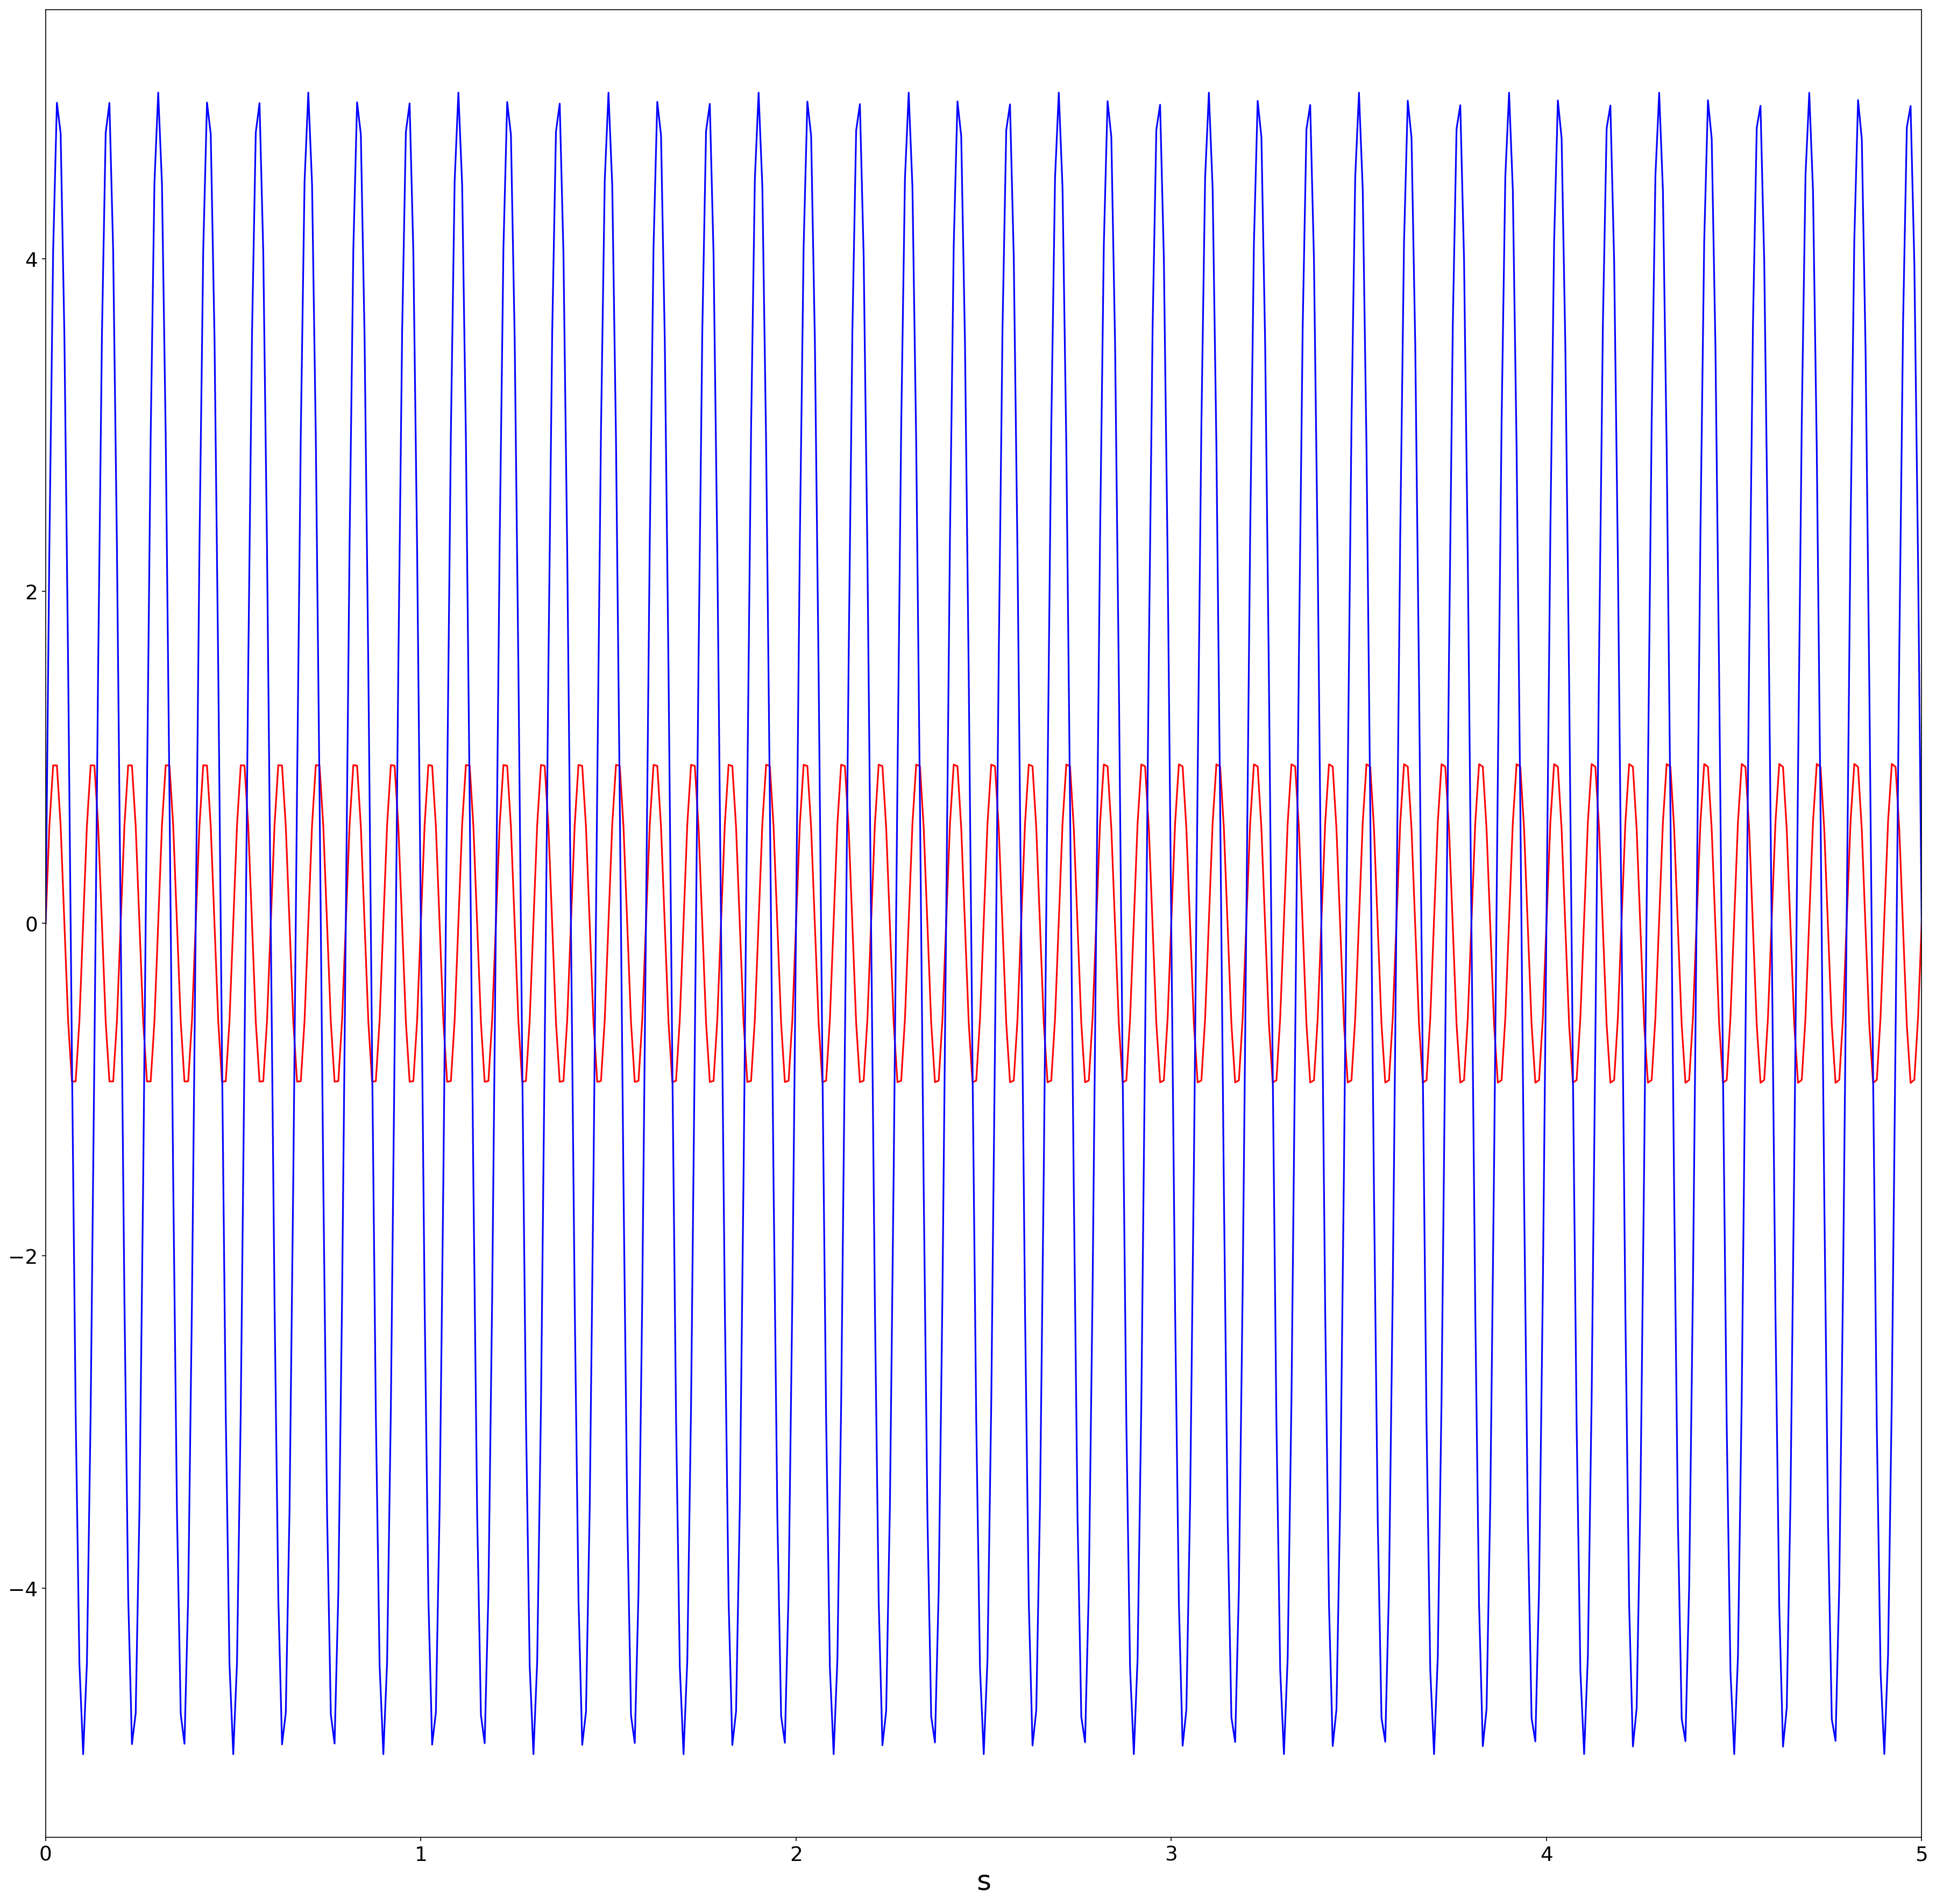

In [68]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r's',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,5))
plt.plot(t,h1,color='red')
plt.plot(t,h2,color='blue')
'''plt.annotate((round(e[121,0],4),round(e[121,1],4)),
             xy=(e[121,0], e[121,1]), xycoords='data',
             xytext=(-300, -50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate((round(e[135,0],4),round(e[135,1],4)),
             xy=(e[135,0], e[135,1]), xycoords='data',
             xytext=(-50, 50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#plt.savefig('lcalresultcombine.png')'''
plt.show()


In [69]:
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
h1f=fft.fft(h1)
h1f1=abs(h1f)
hfabs=2.0/Ng*h1f1[0:Ng//2]

h2f=fft.fft(h2)
h2f2=abs(h2f)
hfabs2=2.0/Ng*h2f2[0:Ng//2]
#angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
#s=sci_interpolate.interp1d(xs,hfgas2)
#anglegas=sci_interpolate.interp1d(xs,hfgas_angle)

In [70]:
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

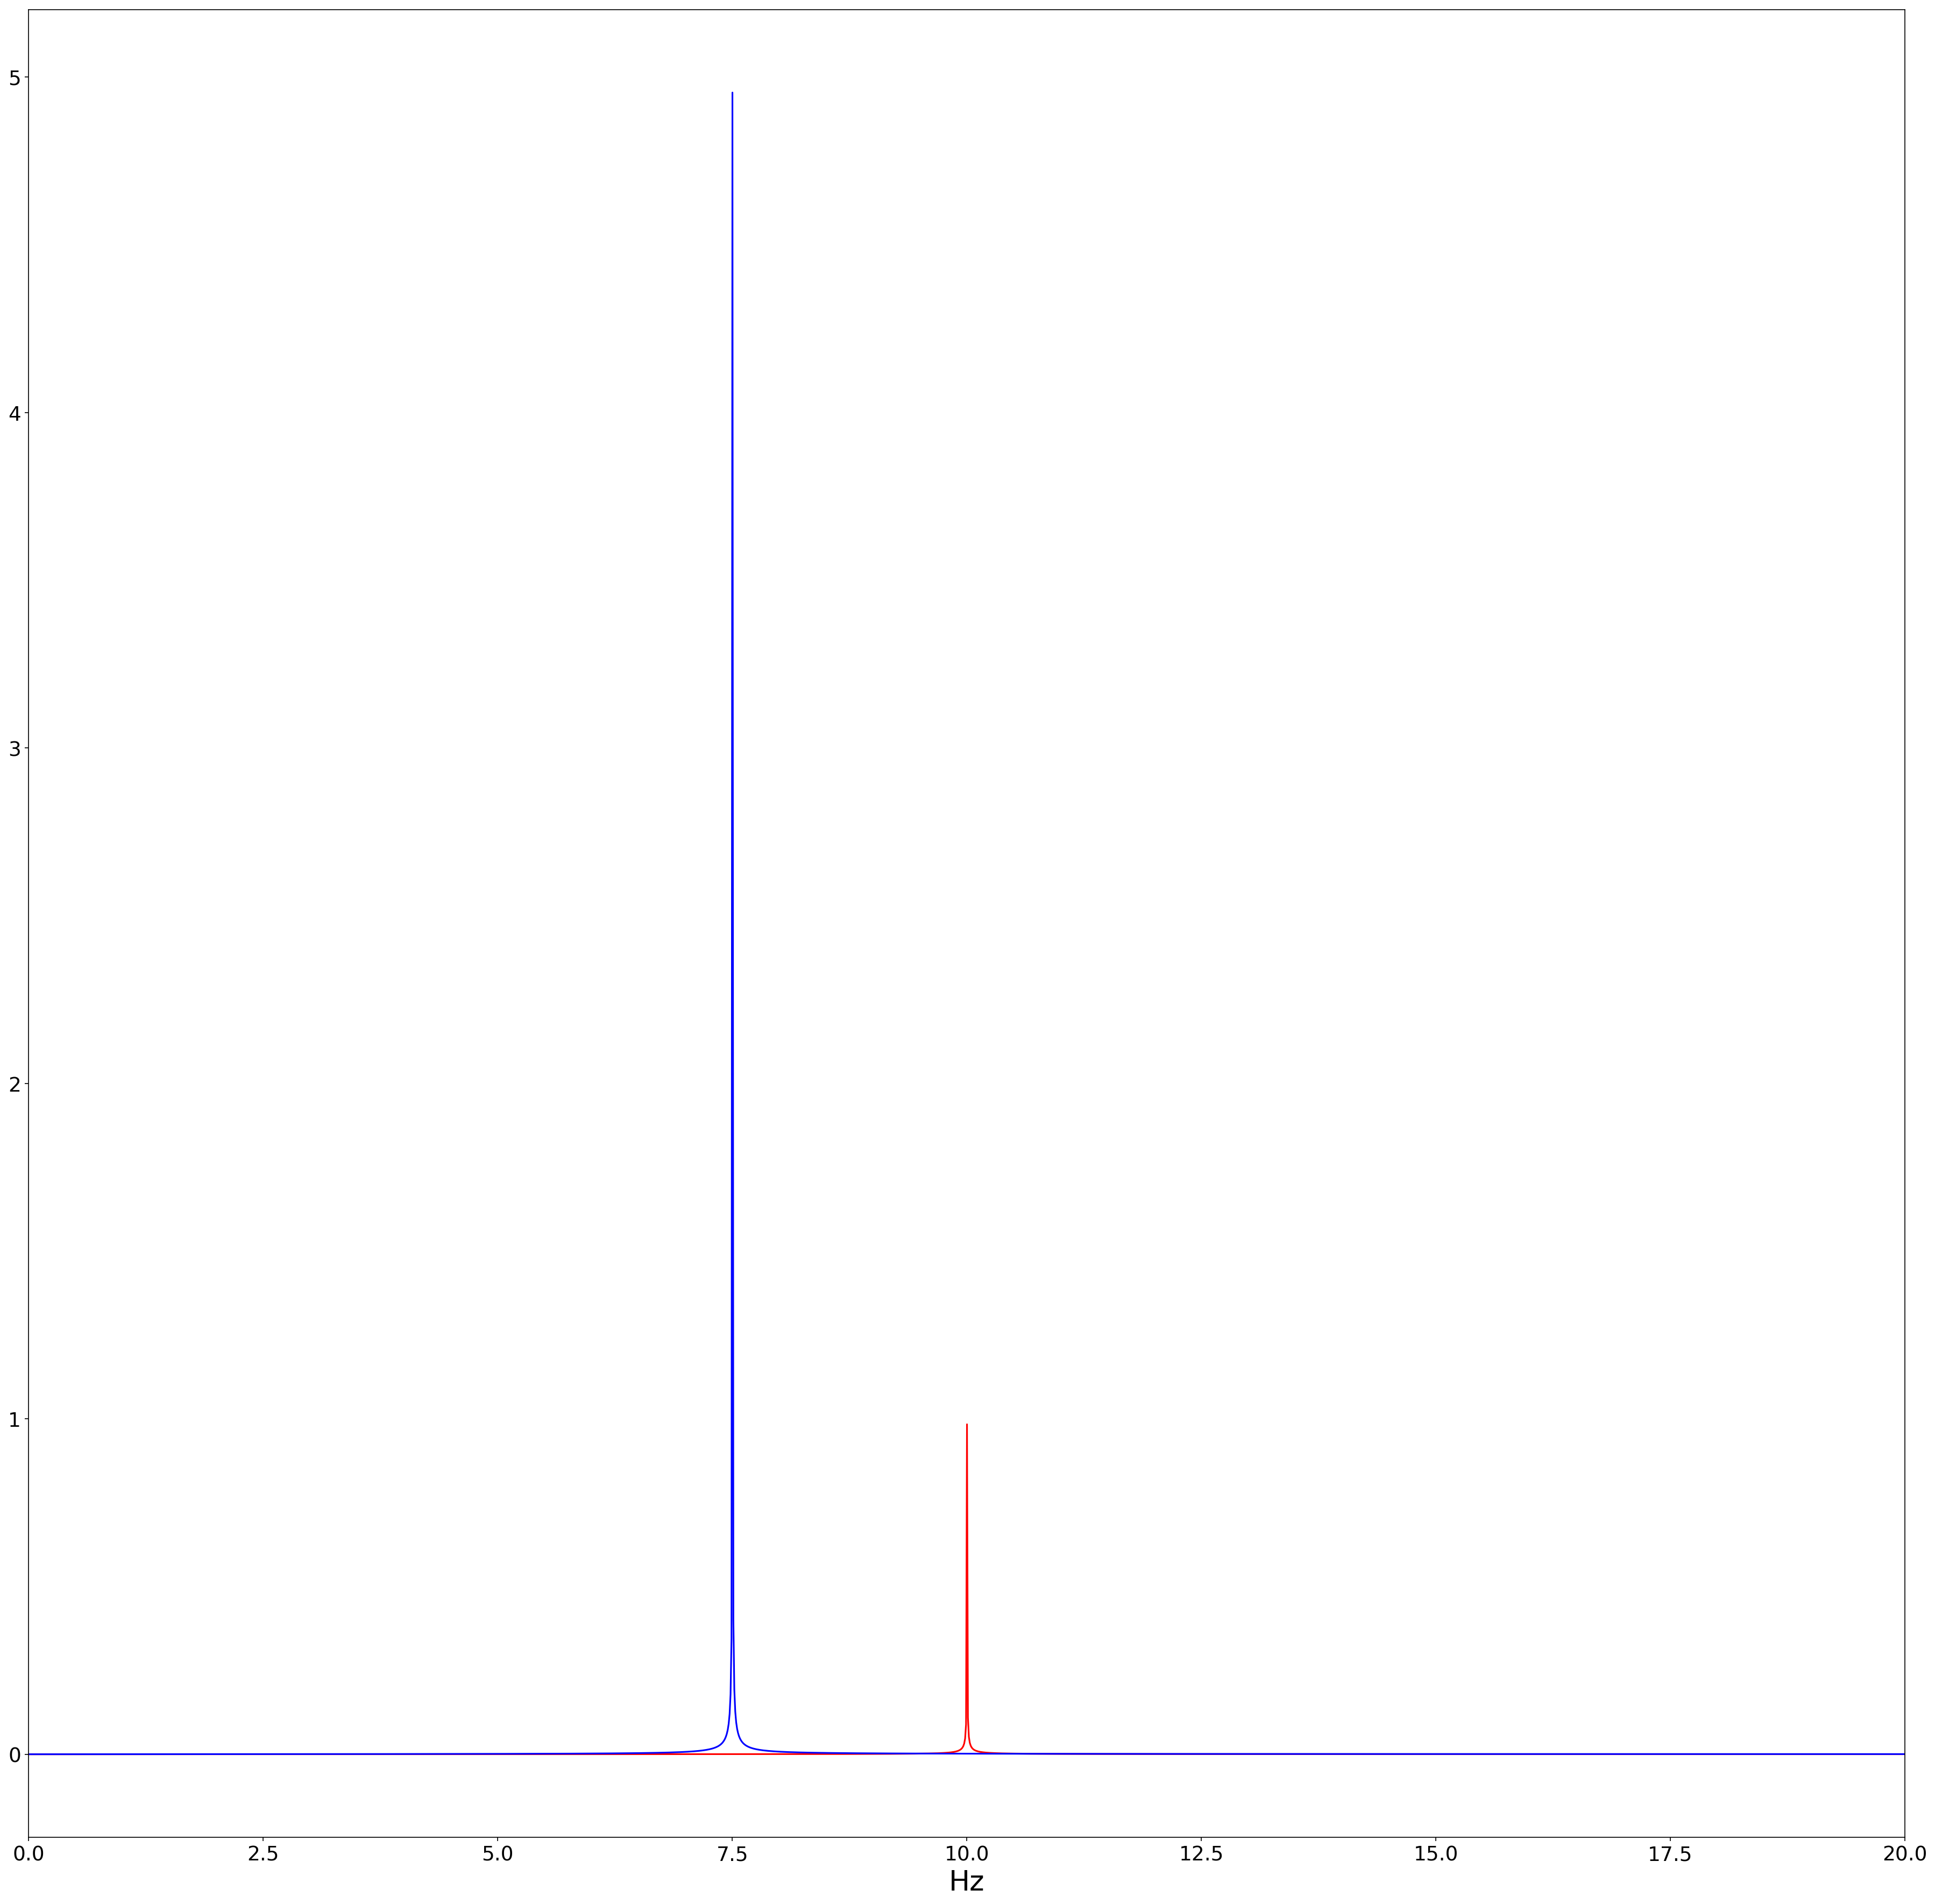

In [74]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r'Hz',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,20))
plt.plot(xs,hfabs,color='red')
plt.plot(xs,hfabs2,color='blue')
'''plt.annotate((round(e[121,0],4),round(e[121,1],4)),
             xy=(e[121,0], e[121,1]), xycoords='data',
             xytext=(-300, -50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate((round(e[135,0],4),round(e[135,1],4)),
             xy=(e[135,0], e[135,1]), xycoords='data',
             xytext=(-50, 50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#plt.savefig('lcalresultcombine.png')'''
plt.show()


In [52]:
#非pingwen 

In [87]:
Ng=100000
t_scale=100.0 
Tg=t_scale/Ng
t=np.linspace(0,t_scale,Ng)
h1=np.sin((20*sciconsts.pi+0.01*t)*t)

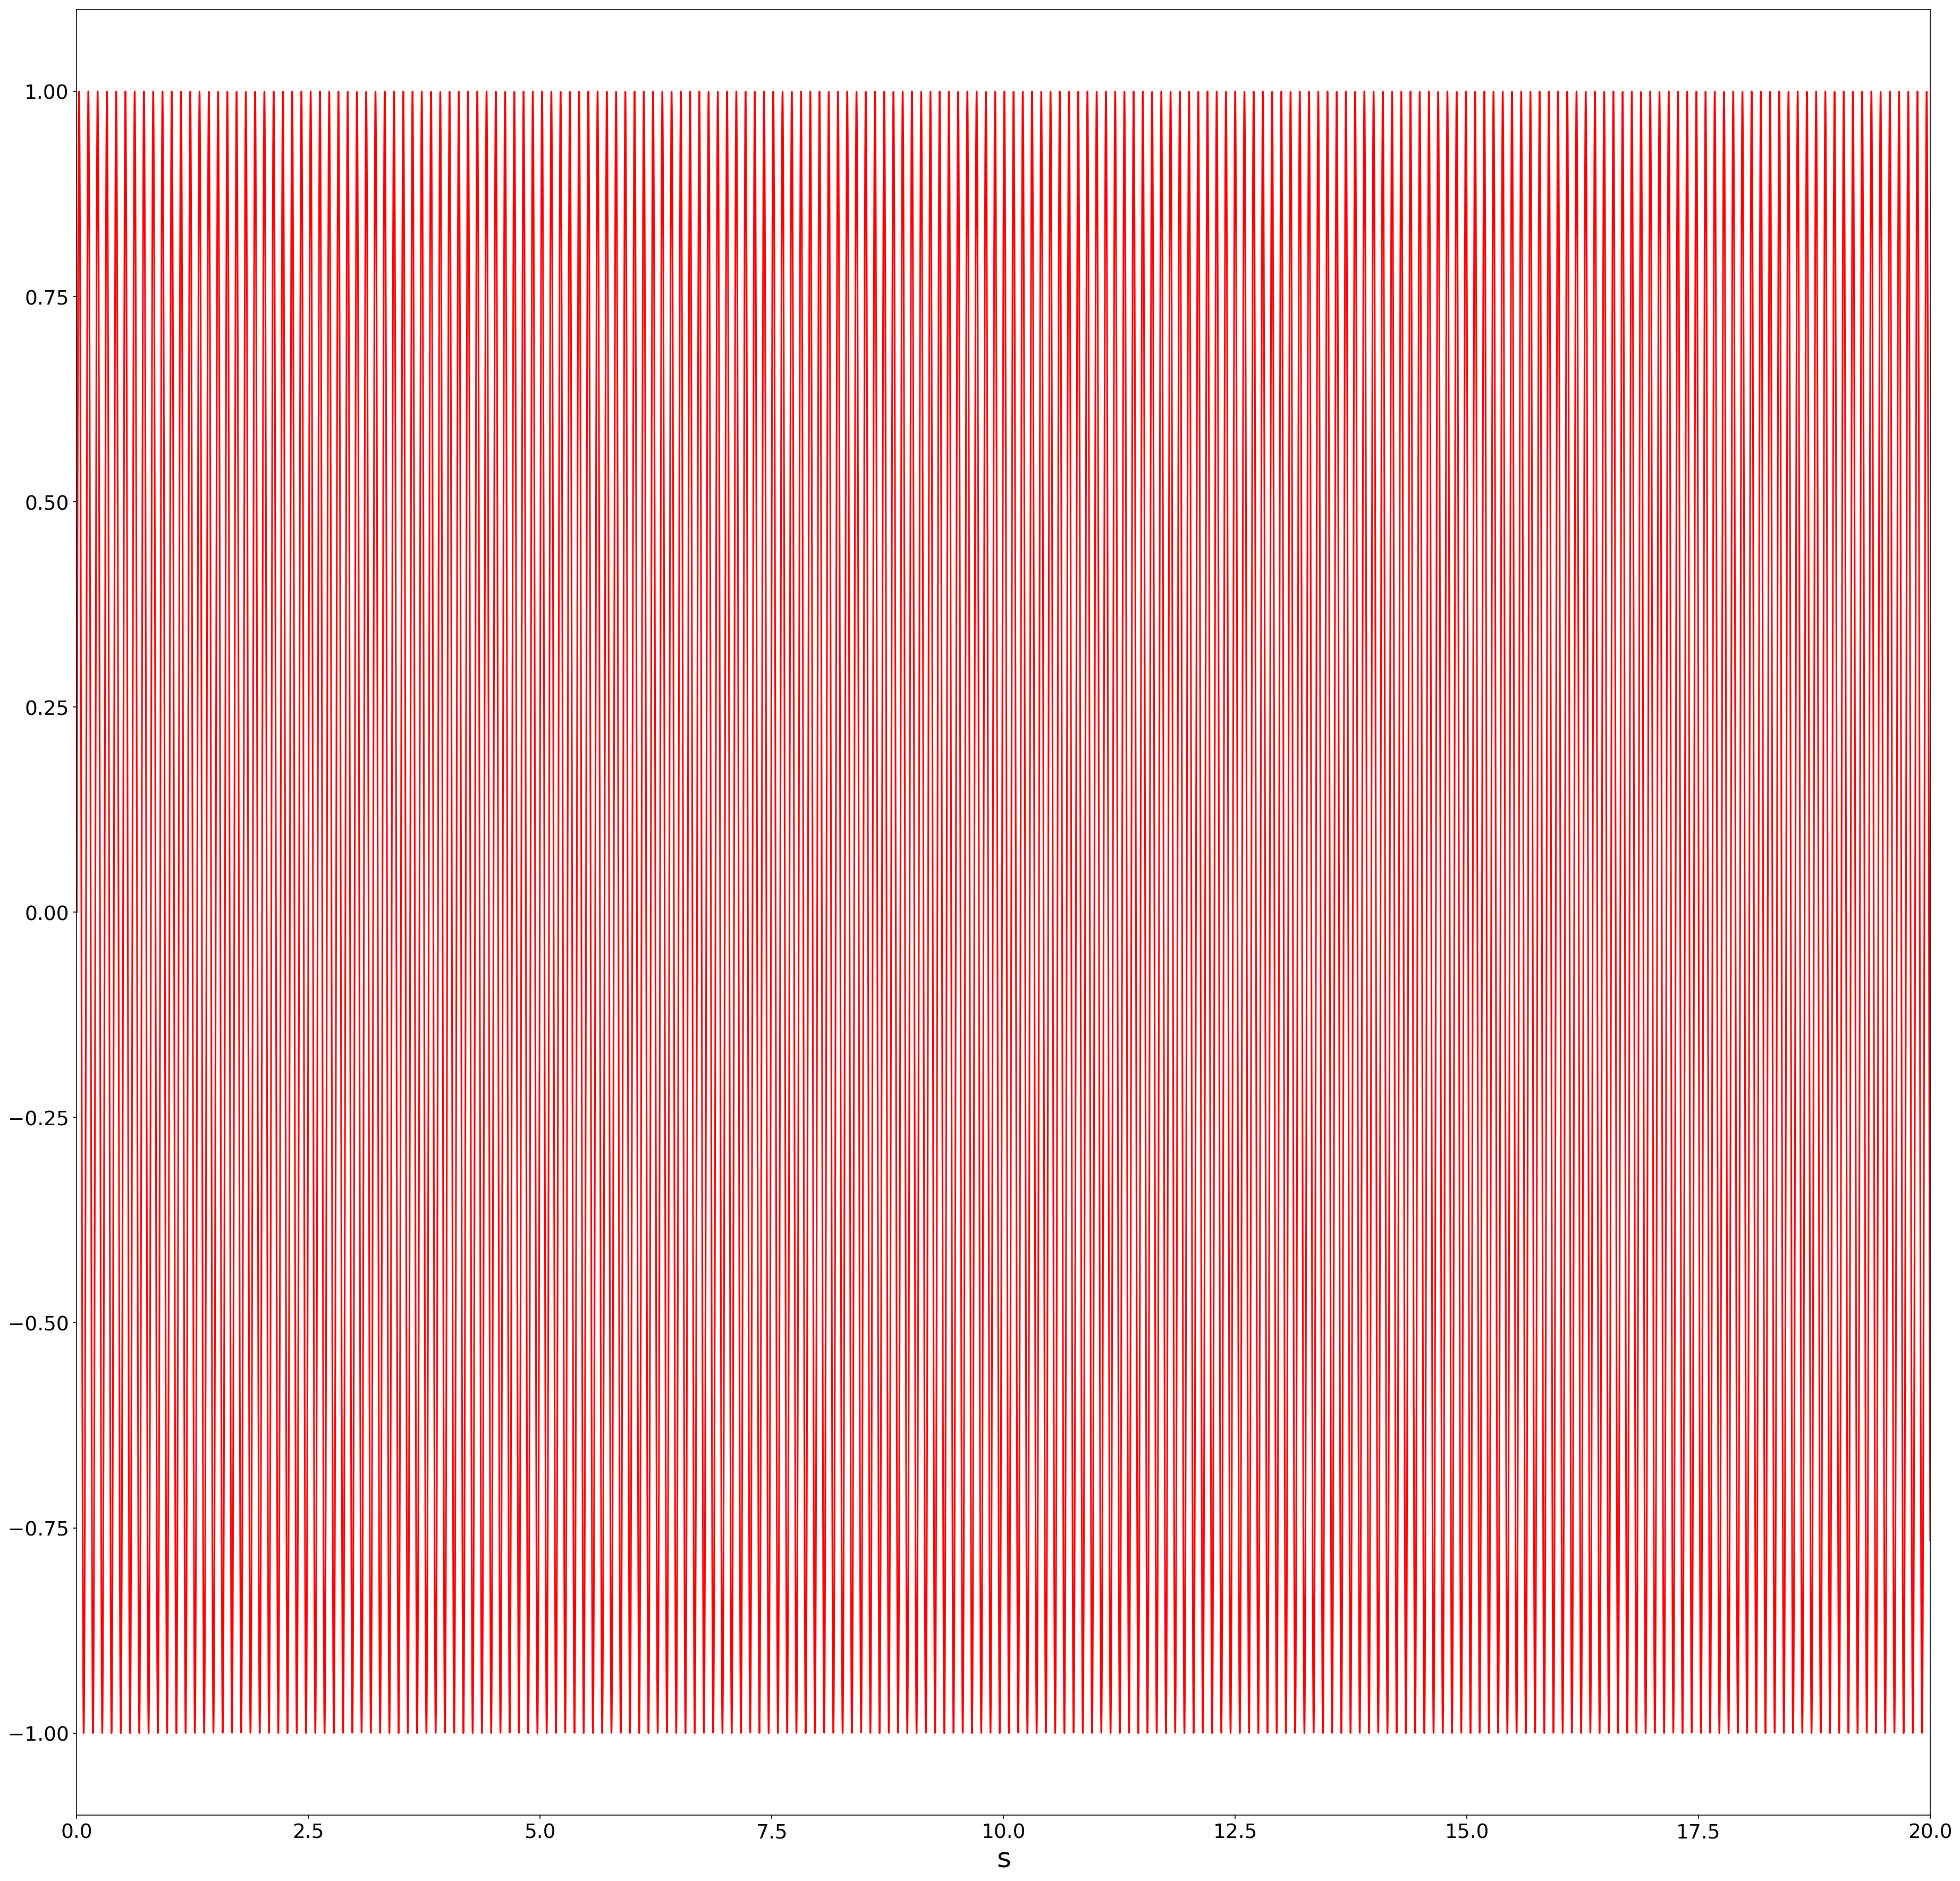

In [88]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r's',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,20))
plt.plot(t,h1,color='red')
'''plt.annotate((round(e[121,0],4),round(e[121,1],4)),
             xy=(e[121,0], e[121,1]), xycoords='data',
             xytext=(-300, -50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.annotate((round(e[135,0],4),round(e[135,1],4)),
             xy=(e[135,0], e[135,1]), xycoords='data',
             xytext=(-50, 50), textcoords='offset points', fontsize=25,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
#plt.savefig('lcalresultcombine.png')'''
plt.show()

In [89]:
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
h1f=fft.fft(h1)
h1f1=abs(h1f)
hfabs=2.0/Ng*h1f1[0:Ng//2]

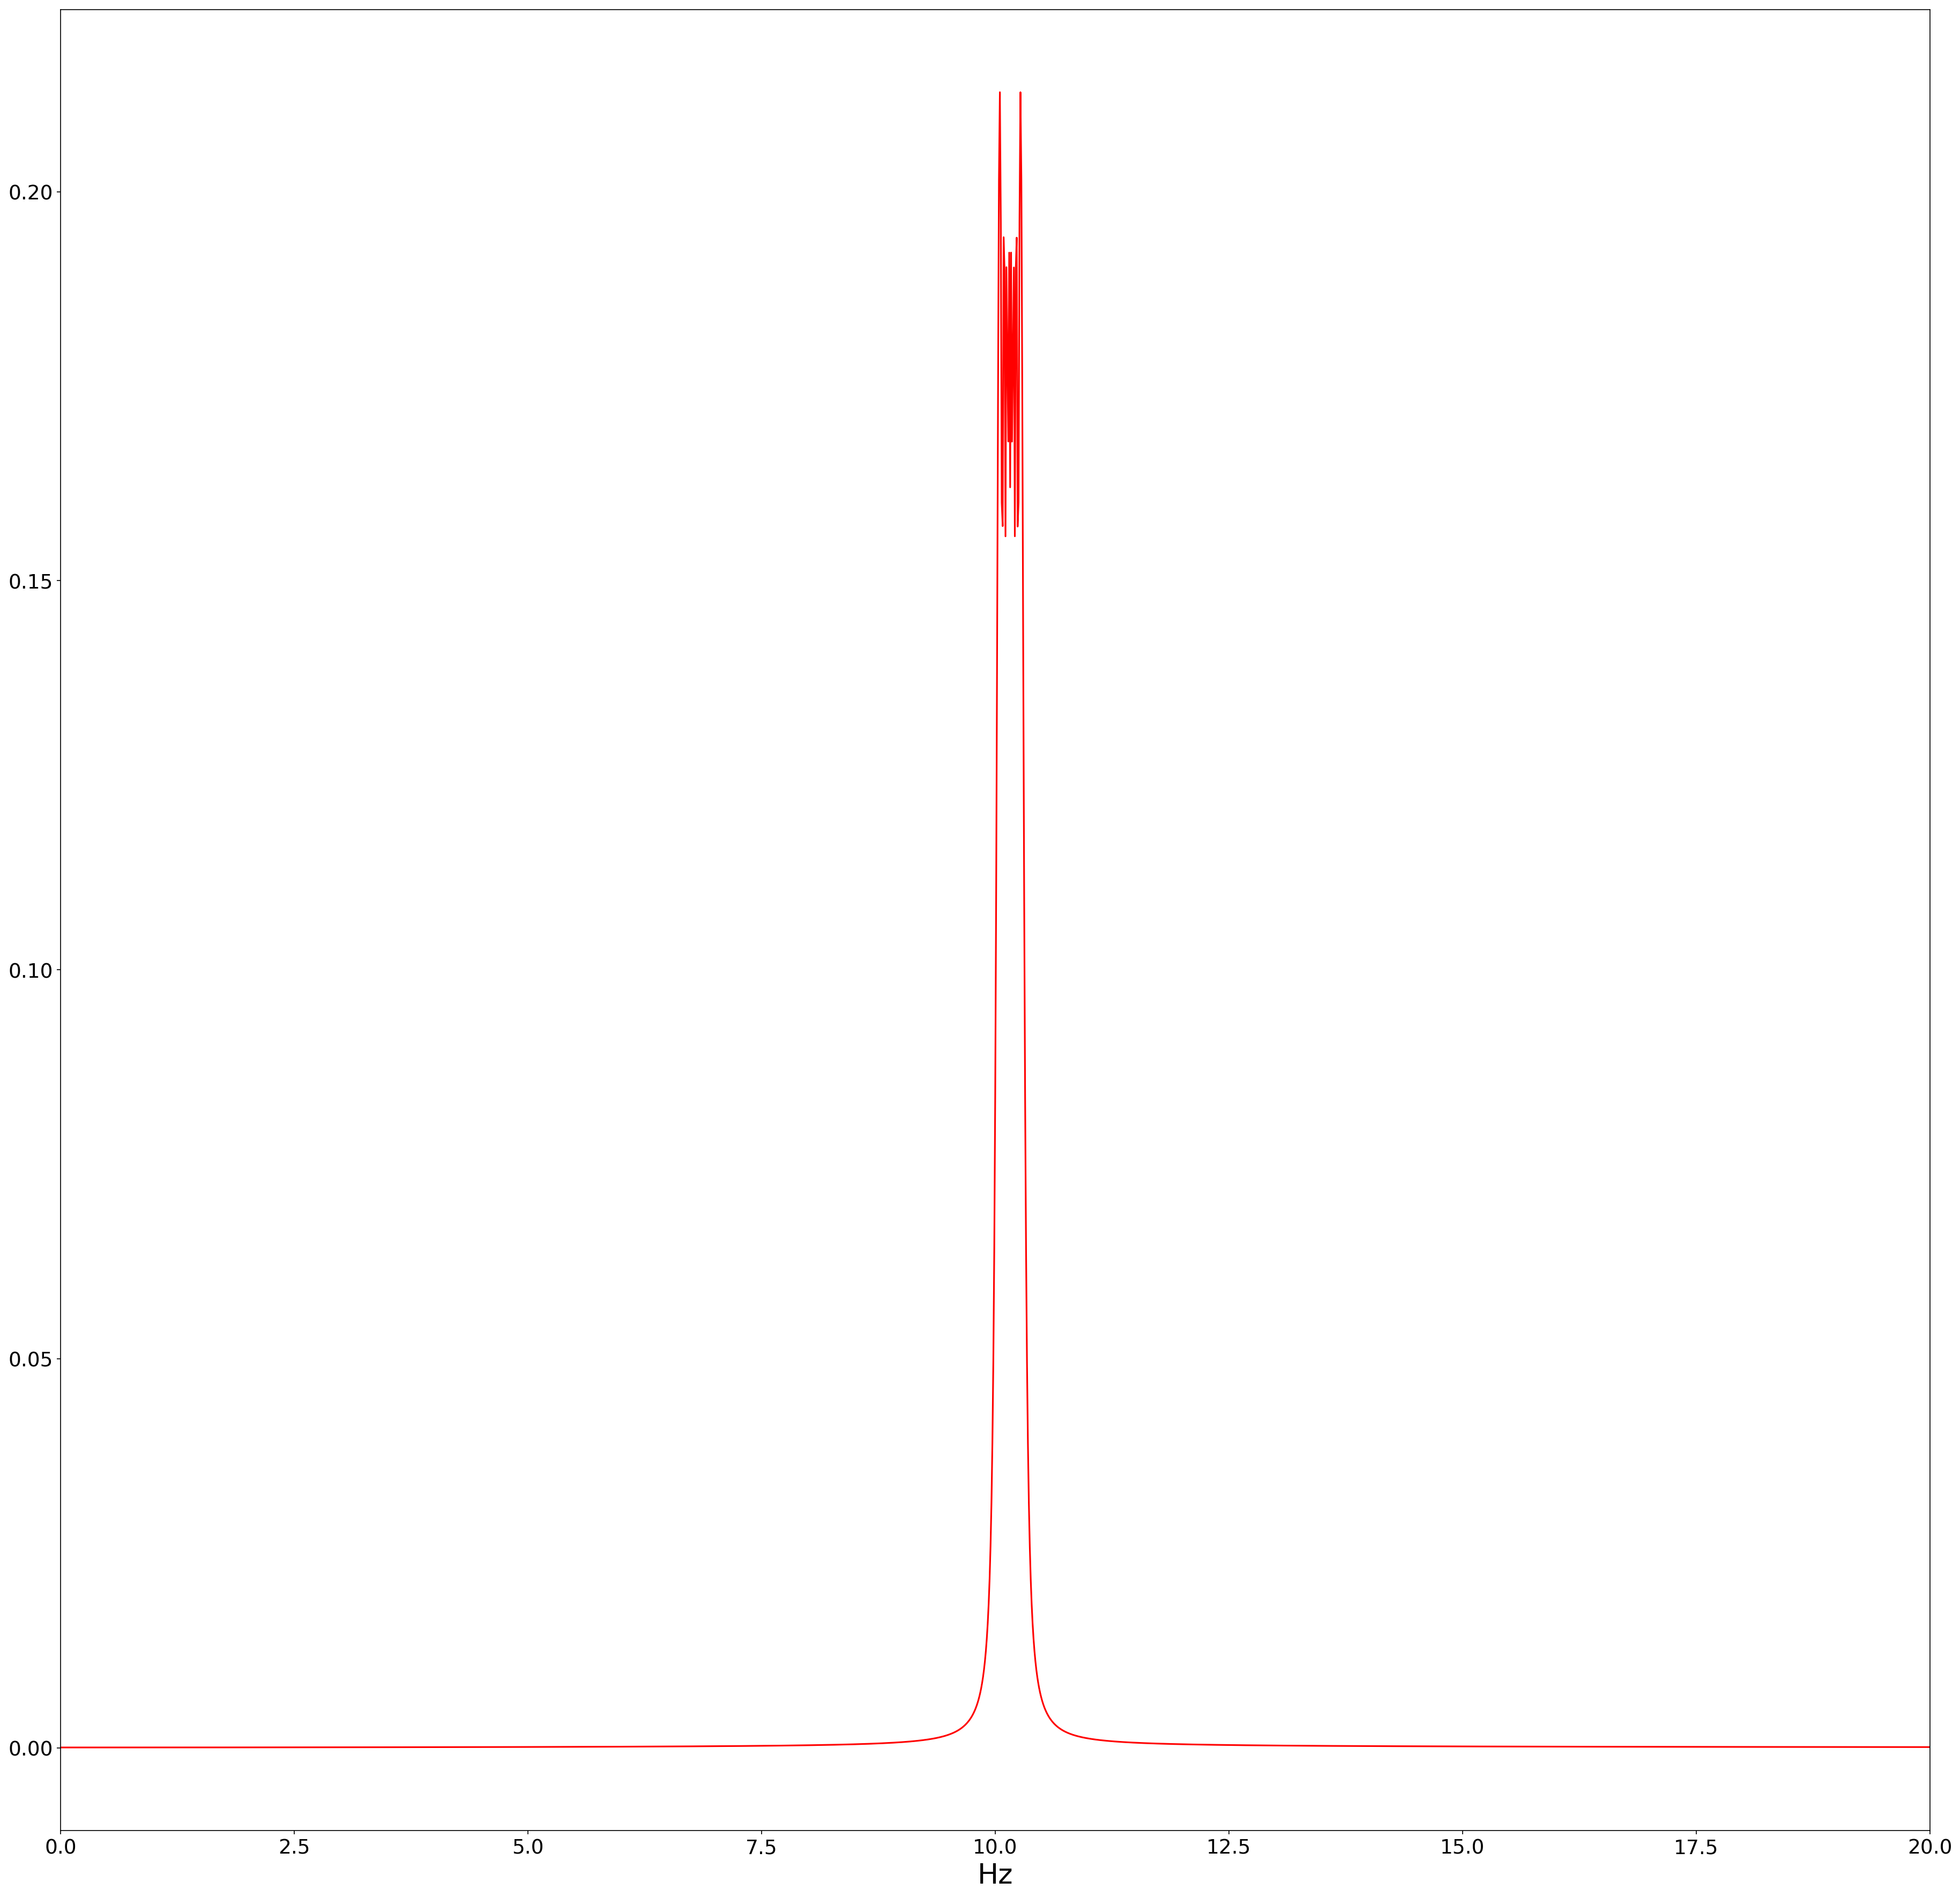

In [90]:
fig1=plt.figure(figsize=(30,30),dpi=150)
#plt.ylabel('FF',fontsize=25)
plt.xlabel(r'Hz',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim((0,20))
plt.plot(xs,hfabs,color='red')
plt.show()

In [91]:
#vac signal